# Price Prediction Model 

## Authors
| **Name**              | **NIU**   |
|-----------------------|-----------|
| Arnau Muñoz Barrera   | 1665982   |
| José Ortín López      | 1667573   |

## Objective

This project has the objective of creating a machine learning model to predict car prices based on various features. This project is based on the Kaggle Car Price Prediction Challenge dataset from Kaggle.

## Database

To access the source Database: [Link to Database](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data)

## Import Libraries

In [62]:
# install required packages in the notebook environment
%pip install pandas numpy seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Note: you may need to restart the kernel to use updated packages.


## Review Initial Structure and Data

In [63]:
df = pd.read_csv('data/vehicles-dataset.csv', engine='python', on_bad_lines='skip')

df.describe(include='all')

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
count,2930,2527,2418,2418,2418,2413,2258,2342,1924,1777,...,1160,1523,1618,2384,2384,0.0,2389,2381.000000,2381.000000,2389
unique,2400,2393,30,30,497,79,38,1014,7,8,...,4,13,12,2081,2144,NaN,4,NaN,NaN,2378
top,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;,rates as low as 2.99%. ;;;;;;;;;;;;;;;;;;;;;...,new york city,https://newyork.craigslist.org,3500,2008,chevrolet,camry,excellent,6 cylinders,...,full-size,sedan,black,https://images.craigslist.org/00505_he8AibINmZ...,BUY HERE PAY HERE ...,NaN,ny,NaN,NaN,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
freq,220,83,445,445,63,180,358,35,843,646,...,641,425,318,7,7,NaN,1883,NaN,NaN,5
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.966901,-75.951059,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.127954,4.900114,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.162608,-121.741100,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.778100,-77.651539,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.605600,-74.011459,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.032056,-73.524000,NaN


##### Determine columns & their types

In [64]:
print("[INFO] Dataset columns & their types: \n", df.dtypes)

[INFO] Dataset columns & their types: 
 id               object
url              object
region           object
region_url       object
price            object
year             object
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer         object
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object


##### Determine quantity of NaNs

[INFO] Does the dataset have missing values? Yes

 [INFO] Percentage of missing values per column: 
 id              0.000000
url             0.001375
region          0.001747
region_url      0.001747
price           0.001747
year            0.001765
fuel            0.001765
odometer        0.001765
transmission    0.001765
title_status    0.001765
posting_date    0.001846
state           0.001846
image_url       0.001863
description     0.001863
lat             0.001874
long            0.001874
model           0.002007
manufacturer    0.002294
condition       0.003433
cylinders       0.003935
drive           0.004389
paint_color     0.004478
type            0.004802
size            0.006041
VIN             0.008870
county          0.010000
dtype: float64


C:\Users\pepor\AppData\Local\Temp\ipykernel_15084\31824092.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Percentage", y="Field", data=df_missing, palette="viridis")


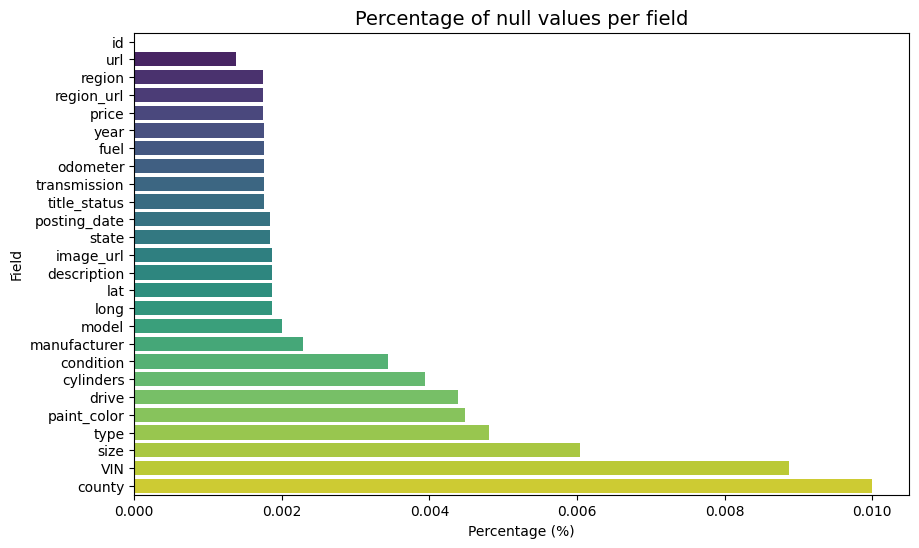

In [65]:
# Auxiliar function to display missing values
def has_nans(df):
    return df.isna().sum().sum() > 0

# Auxiliar function to display percentage of missing values per column
def get_percentage_nan_per_column(df):
    return ((df.isna().sum().sort_values()) / (len(df) * 100))

print("[INFO] Does the dataset have missing values?", "Yes" if has_nans(df) else "No")

if has_nans(df):
    print("\n [INFO] Percentage of missing values per column: \n", get_percentage_nan_per_column(df))

    df_missing = pd.DataFrame(list(get_percentage_nan_per_column(df).items()), columns=["Field", "Percentage"])

    plt.figure(figsize=(10,6))
    sns.barplot(x="Percentage", y="Field", data=df_missing, palette="viridis")

    plt.title("Percentage of null values per field", fontsize=14)
    plt.xlabel("Percentage (%)")
    plt.ylabel("Field")

    plt.show()
else:
    print("\n [INFO] No missing values detected in the dataset.")

### Conclusions

As we can see in previous results, the main initial factors that should be revised & look into are:

| **Problem description**                                | **Proposed Solution**      | **Affected fields**      |
|--------------------------------------------------------|----------------------------|--------------------------|
| Fields with different types or inconsistent ranges     | Normalization & Preprocessing             | **Dataframe**            |
| Field that needs format clean-up                       | Field modifications        | **posting_date**         |
| Field with most NaN values                             | Erase column               | **county**, **VIN**      |
| Target field with NaN values                             | Erase row               | **price**      |
| Field that needs change of type                        | Type modification          | **price**                |

### Clean Up ***Posting_date*** 


In [66]:
df["posting_date"] = df["posting_date"].str.replace(";", "", regex=False)

print("[INFO] Posting date field after cleaning: \n", df['posting_date'].head())

[INFO] Posting date field after cleaning: 
 0    2021-04-13T09:59:51-0400
1    2021-04-12T16:40:04-0400
2    2021-04-12T16:30:35-0400
3    2021-04-12T16:25:04-0400
4    2021-04-12T16:19:55-0400
Name: posting_date, dtype: object


### Modify type of ***Price*** & Erase rows with empty ***Price***

In [67]:
# Conversion of price to numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")

print("[INFO] Price field after conversion to numeric: \n", df['price'].head())

# Filtering the rows of cars that have a price greater than 0 
df = df[df["price"] > 0].copy()
# Creation of new column containing the natural logarithm of the price
df["log_price"] = np.log(df["price"])

# Replace any such value with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remove al NaN values from both the price and log_price columns
df.dropna(subset=["price", "log_price"], inplace=True)

get_percentage_nan_per_column(df)


[INFO] Price field after conversion to numeric: 
 0    22000.0
1     8250.0
2     6850.0
3     6250.0
4     4250.0
Name: price, dtype: float64


id              0.000000
url             0.000000
region          0.000000
region_url      0.000000
price           0.000000
log_price       0.000000
posting_date    0.000000
state           0.000000
transmission    0.000021
title_status    0.000021
fuel            0.000021
description     0.000021
image_url       0.000021
year            0.000021
odometer        0.000021
long            0.000034
lat             0.000034
model           0.000279
manufacturer    0.000656
condition       0.001997
cylinders       0.002611
drive           0.003064
paint_color     0.003165
type            0.003563
size            0.005099
VIN             0.008726
county          0.010000
dtype: float64

### Normalization & Preprocessing 

In [68]:
# Categorical and numerical columns
categorical_cols = [
    "region", "manufacturer", "model", "condition", 
    "cylinders", "fuel", "transmission", "drive", 
    "size", "type", "paint_color"
]

numeric_cols = ["year", "odometer"]

# Confirm that the numeric variables are numeric
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Delete all the rows of the categorical variables, numerical variables, price and log_price
df = df.dropna(subset=numeric_cols + categorical_cols + ["log_price", "price"])

# 3) One-Hot Encoding for the categorical variables
ohe = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False 
)

# fit the encoder and transform the categorical variables
X_cat = ohe.fit_transform(df[categorical_cols])

# Obtain the names of the new one-hot encoded columns
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)

# Convert them into a DataFrame aligned with the index of df
X_cat_df = pd.DataFrame(X_cat, columns=encoded_cat_cols, index=df.index)

# Extract the numerical columns
X_num_df = df[numeric_cols]

# 5) Concatenate categorical (one-hot) + numerical → final features X
X = pd.concat([X_cat_df, X_num_df], axis=1)

# Define the targets
y_log  = df["log_price"]   # target log scale
y_real = df["price"]       # target in real euros

X.head()


,region_akron / canton,region_albany,region_ashtabula,region_athens,region_binghamton,region_bismarck,region_buffalo,region_chautauqua,region_chillicothe,region_cincinnati,...,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,year,odometer
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1961.0,85000.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,137369.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,126461.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2006.0,109566.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999.0,112566.0


### Erase cols ***County*** & ***VIN***

In [69]:
df = df.drop(['county', 'VIN'], axis=1)
df.describe(include='all')

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,state,lat,long,posting_date,log_price
count,938,938,938,938,938.000000,938.000000,938,938,938,938,...,938,938,938,938,938,938,938.000000,938.000000,938,938.000000
unique,938,938,28,28,NaN,NaN,36,505,6,7,...,4,12,12,819,838,4,NaN,NaN,937,NaN
top,7306114308,https://albany.craigslist.org/cto/d/amsterdam-...,new york city,https://newyork.craigslist.org,NaN,NaN,chevrolet,silverado,excellent,6 cylinders,...,full-size,sedan,black,https://images.craigslist.org/00k0k_evBx86aYXx...,Power Windows / Locks Tilt & Cruise Like New T...,ny,NaN,NaN,2021-05-02T19:52:17-0400,NaN
freq,1,1,178,178,NaN,NaN,150,21,422,378,...,530,279,185,5,5,749,NaN,NaN,2,NaN
mean,NaN,NaN,NaN,NaN,9221.248401,2007.168443,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,42.184154,-76.357086,NaN,8.801373
std,NaN,NaN,NaN,NaN,8730.624972,9.387620,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.699215,5.425372,NaN,0.866547
min,NaN,NaN,NaN,NaN,1.000000,1923.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33.471700,-103.865000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,3995.000000,2005.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,40.813257,-77.653900,NaN,8.292799
50%,NaN,NaN,NaN,NaN,6575.000000,2008.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,42.054322,-74.056603,NaN,8.791023
75%,NaN,NaN,NaN,NaN,11000.000000,2012.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43.049800,-73.682600,NaN,9.305651


##### Analysis of correlations with **target**: '***Price***'

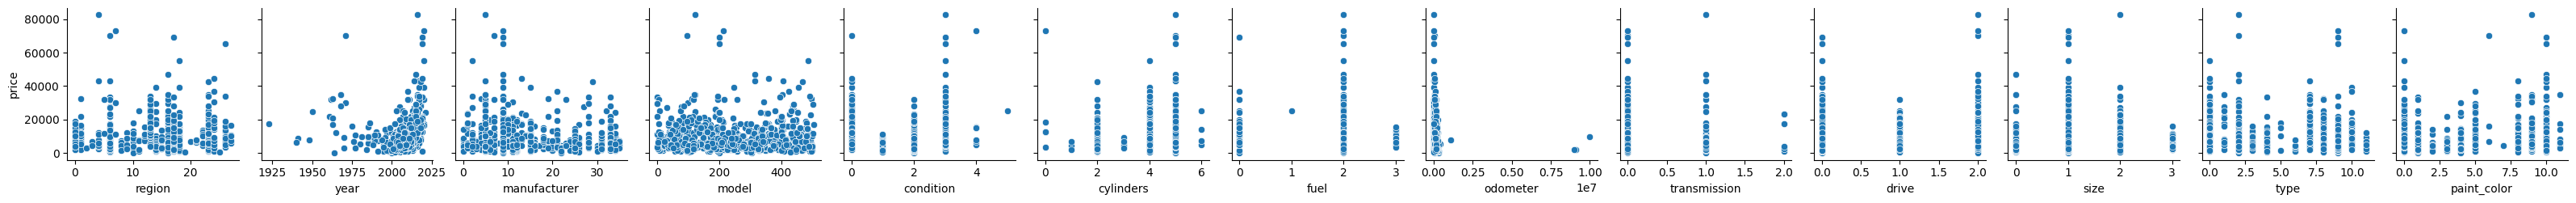

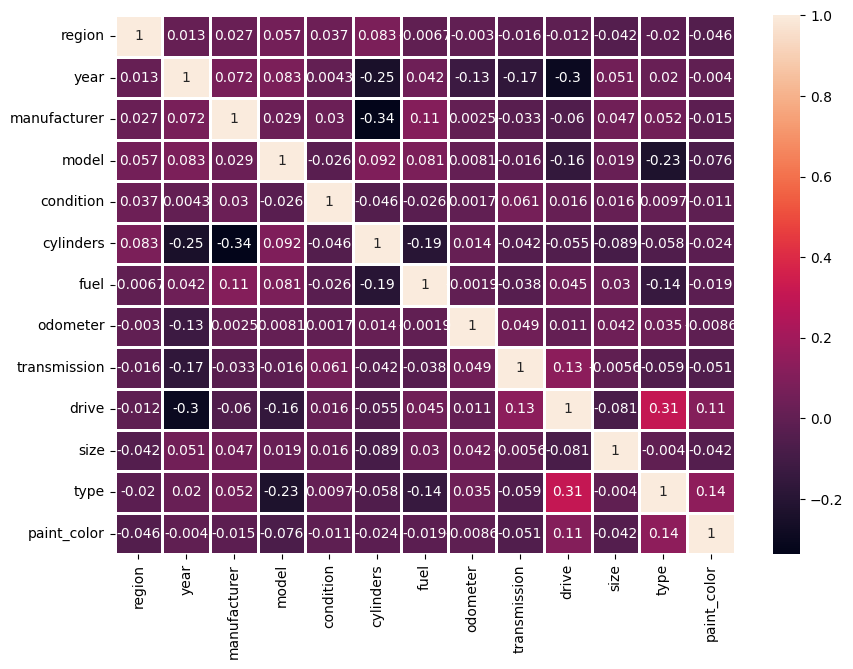

In [ ]:
# Fields to use
cols = ["region", "year", "manufacturer", "model", "condition", "cylinders",
        "fuel", "odometer", "transmission", "drive", "size", "type", "paint_color"]

# Nos quedamos con price + todas las columnas de interés
df_plot = df[["price"] + cols].dropna(subset=["price"] + cols).copy()

# Convert categorical to numeric numbers (0,1,2,...) for graphics
for col in cols:
    if df_plot[col].dtype == "object":
        df_plot[col] = df_plot[col].astype("category").cat.codes

# All the colums now are numeric
numeric_cols = cols

sns.pairplot(
    df_plot,
    y_vars=["price"],
    x_vars=numeric_cols,
    kind="scatter",
    dropna=True
)

# Correlation heatmap 
plt.figure(figsize=(10, 7))

corr = df_plot[numeric_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    linewidths=2
)
plt.show()

##### ☣️ Is the data balanced?

In [71]:
entropies= df.apply(lambda col: entropy(col.value_counts(normalize=True), base=2)/np.log2(col.nunique()))
entropies

id              1.000000
url             1.000000
region          0.762794
region_url      0.762794
price           0.916442
year            0.799715
manufacturer    0.815434
model           0.948475
condition       0.693136
cylinders       0.617474
fuel            0.163717
odometer        0.949305
title_status    0.135256
transmission    0.262493
drive           0.910148
size            0.718609
type            0.786794
paint_color     0.817689
image_url       0.989137
description     0.990958
state           0.516230
lat             0.924614
long            0.924954
posting_date    0.999940
log_price       0.916442
dtype: float64

## Metric Selection

In this section, we will focus on selecting the appropriate classification metrics and mechanisms to analyze the performance of our final model. To do so, we will train our data using logistic regression and generate a set of functions to evaluate the results, such as graphical functions (Precision-Recall Curve and ROC Curve).

The metrics we are going to analyze are the following: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Coefficient of Determination (R²). Once we obtain the results and functions, we will decide which metric to use in order to select the best-performing model.

In [72]:
# Declaration of functions to analyze the metrics:
def calculMetriques(y_true, y_pred, metric='mse'):
    if metric == 'mse':
        result = mean_squared_error(y_true,y_pred)
    elif metric == 'rmse':
        result = np.sqrt(mean_squared_error(y_true,y_pred))
    elif metric == 'mae':
        result = mean_absolute_error(y_true,y_pred)
    elif metric == 'r2':
        result = r2_score(y_true,y_pred)
    else:
        raise ValueError("Métrica no reconocida")

    return result

In [73]:
def mostrar_grafics (y, y_pred):
    # Scatter plot between real values (y) and predicted values (y_pred)
    plt.scatter(y,y_pred)
    # Add a red line representing the ideal line (y = y_pred)
    plt.plot(y,y,'--',c = 'red')
    plt.xlabel('y_real') # Label for the X-axis
    plt.ylabel('y_pred') # Label for the Y-axis
    plt.show()           # Display the plot

    # Scatter plot of the errors (difference between y_pred and y)
    plt.scatter(y,y_pred-y)
    plt.xlabel('y_real') 
    plt.ylabel('error')  # Label for the Y-axis (error)
    plt.show()

    # Scatter plot of the absolute error (MAE) for each y value
    plt.scatter(y,abs(y_pred-y))
    plt.xlabel('y_real') 
    plt.ylabel('MAE')    # Label for the X-axis (Mean Absolute Error)
    plt.show()

    # Gràfic de dispersió del MAPE (error absolut relatiu per cada valor de y)
    plt.scatter(y,abs(y_pred-y)/y)
    plt.xlabel('y_real') 
    plt.ylabel('MAPE')   # Label for the X-axis (Mean Absolute Percentage Error)
    plt.show()

Mètriques: 
 Mean Squared Error (MSE): 10737153.312956832
 Root Mean Squared Error (RMSE): 3276.7595750919586
 Mean Absolute Error (MAE): 1342.1499655240877
 Coefficient of Determination (R²): 0.8589861612898307


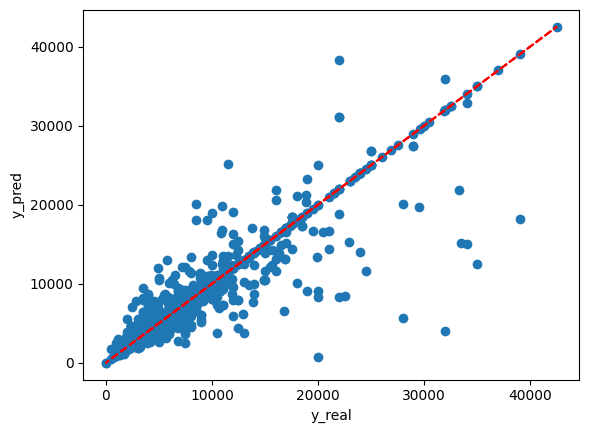

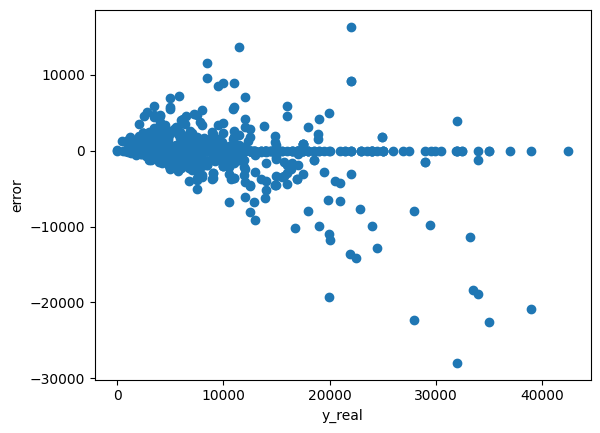

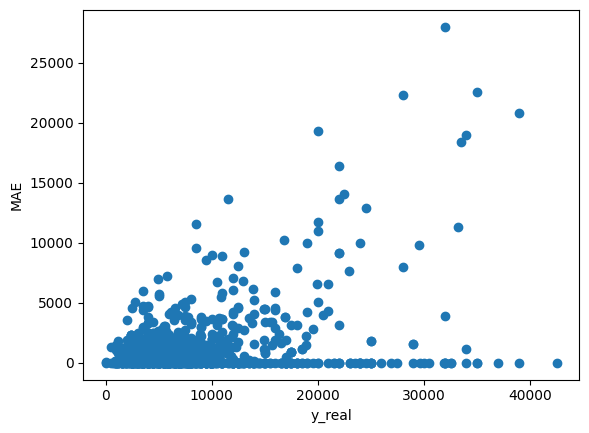

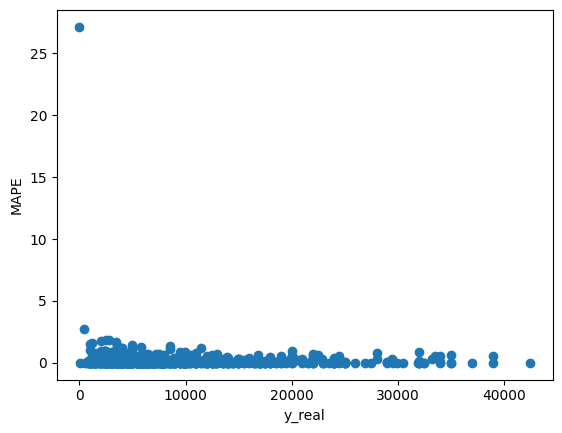

In [74]:
target_att = "price"

# We apply the linear regression model
model = LinearRegression()

# Train the model
model.fit(X, y_log)

# Model prediction
y_pred_log = model.predict(X)
# Transform the log scale back to the original scale
y_pred = np.exp(y_pred_log)   # back to euros

print("Mètriques: ")
print(" Mean Squared Error (MSE):",  calculMetriques(y_real, y_pred, metric="mse"))
print(" Root Mean Squared Error (RMSE):", calculMetriques(y_real, y_pred, metric="rmse"))
print(" Mean Absolute Error (MAE):", calculMetriques(y_real, y_pred, metric="mae"))
print(" Coefficient of Determination (R²):", calculMetriques(y_real, y_pred, metric="r2"))

# ---- Quitar solo outliers del gráfico ----
p99 = y_real.quantile(0.99)
mask = y_real <= p99

y_plot = y_real[mask]
y_pred_plot = y_pred[mask]

mostrar_grafics(y_plot, y_pred_plot)


Un cop analitzats els resultats amb les diferents mètriques i mecanismes escollirem quina mètrica utilitzarem per avaluar els rendiments dels models i escollir el que més s'adapta al nostre dataset.

##### Mètriques escollides per avaluar el nostre model
* **Mean Squared Error (MSE)**:

    Mesura l'error quadràtic mitjà entre els valors reals i els predits

    Ens aporta informació sobre com de grans són els errors, penalitzant especialment els errors grans. També ens dona una idea general de la precisió del model.

    $MSE=\frac{1}{m}\sum_{i=1}^{m}(y_i-\hat{y}_i)^2$

    <span style="color: red;">✗ *Mètrica no escollida*</span>

* **Root Mean Squared Error (RMSE)**:
    Arrel quadrada del MSE.

    Ens aporta informació de quants euros ens equivoquem de mitjana en les prediccions. És una mètrica útil perquè ens aporta una visió global del rendiment.

    $RMSE=\sqrt{MSE}$

    <span style="color: red;">✗ *Mètrica no escollida*</span>

* **Mean Absolute Error (MAE)**:
    Calcula l'error mitjà en valor absolut
    
    Ens aporta informació de quant s'equivoca el model de mitjana en valor absolut. A diferència del MSE, no penalitza en excés els outliers. Es una mètrica de gran utilitat quan volem tenir una mesura concreta del comportament global del model sense que els errors molt grans afectin a la mètrica

    $MAE=\frac{1}{m}\sum_{i=1}^{m}\lvert y_i-\hat{y}_i\rvert$

    <span style="color: green;">✔ *Mètrica escollida*</span>

* **Coefficient of Determination (R²)**:
    Percentatge de la variabilitat del preu és explicat pel model

    Ens aporta informació sobre com de bé el model explica l'estructura del dataset. Quan ens trobem amb un R² baix significa que el model no es capaç de capturar la relació entre les variables d'entrades i la variable target (preu). En canvi, quan tenim un R² gran el model es capaç de justificar les variacions en els preus.Es una mètrica de gran utilitat per comparar models amb diferents complexitats 
    


    $R^2 = 1-\frac{\sum_{i=1}^{m}(y_i-\hat{y}i)^2}{\sum{i=1}^{m}(y_i-\bar{y})^2}$
    
    on $\bar{y}$ és la mitjana dels valors reals

    <span style="color: green;">✔ *Mètrica escollida*</span>

## Model Selection with cross-validation

In this case, for the supervised regression task of predicting vehicles prices, we considered the following models:

### **Linear Regression**

### **Lasso Regression (L1 Regularization)**
This technique adds a penalty term that is proportional to the sum of the absolute values of the coefficients. This forces some of the coefficients to become exactly zero when the tunning parameter λ is sufficiently large. This property makes this technique useful for feature selection
### **Ridge Regression (L2 Regularization)**
This technique adds a penalty term that is proportional to the sum of the squares of the coefficients. Ridge does not force coefficients to become exactly zero. Instead, it tends to shrink all coefficients equally, keeping them small but non-zero

### **Decision Tree Regressor**
Model which predicts numerical values using a tree-like structure. This model has the capacity of capturing nonlinear relationships and feature interactions whithout requiring manual feature engineering

### **Random Forest Regressor**
Model which works by creating multiple of decision trees each trained on a random subset of the data. This model reduces overfitting and generally works well on tabular datasets

### **Suport Vector Regressor (SVR)**
Despite the fact this model was created classification problems, you can also use it for solving regression problems. The model can model moderately complex nonlinea relationships and is very effective for high-dimensional feature spaces

### **K-Nearest Neighbors Regressor (KNN)**

Is a non-parametric supervised learning method which predicts based on the average of the K nearest neighbors. This model serves as a flexible reference model that captures local structure.


We are gonna use the cross-validation because is essential to obtain reliable estimation of the model's performance and reduce the dependence on data partitioning. Unlike a simple train/test split, cross-validation provides a measure of performance over various partitions, thus avoiding conclusions based on an unrepresentative validation set.

Also we decided to use a specific type of cross-validation called RepeatedKFold. This decisions is based on the idea that we needed an specific strategy that provides stable and realiable estimates of model performance due to the different behaviors of the algorithms. RepeatedKFold is appropiate in our context because repeating the cross-validation process multiple times, we ensure that our evaluation is not overly dependent on a specific random partition of the data.